##DATA PIPELINE

In [ ]:
import os
import pandas as pd
import sqlite3
import requests
import webbrowser

# URLs for the datasets
urls = {
    "energy_consumption_by_sector": "https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/ten00124?format=TSV&compressed=false",
    "GHG_emissions": "https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/sdg_13_10?format=TSV&compressed=false",
    "climate_related_expenditure": "https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/sdg_13_50?format=TSV&compressed=false"
}

# Data directory
output_dir = "output"
tsv_paths = {
    "energy_consumption_by_sector": os.path.join(output_dir, "final_energy_consumption_by_sector.tsv"),
    "GHG_emissions": os.path.join(output_dir, "net_greenhouse_gas_emissions.tsv"),
    "climate_related_expenditure": os.path.join(output_dir, "climate_related_expenditure.tsv")
}
excel_paths = {
    "energy_consumption_by_sector": os.path.join(output_dir, "final_energy_consumption_by_sector.xlsx"),
    "GHG_emissions": os.path.join(output_dir, "net_greenhouse_gas_emissions.xlsx"),
    "climate_related_expenditure": os.path.join(output_dir, "climate_related_expenditure.xlsx")
}
database_paths = {
    "energy_consumption_by_sector": os.path.join(output_dir, "final_energy_consumption_by_sector.db"),
    "GHG_emissions": os.path.join(output_dir, "net_greenhouse_gas_emissions.db"),
    "climate_related_expenditure": os.path.join(output_dir, "climate_related_expenditure.db")
}

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Function to download and save files
def download_file(url, file_path):
    if not os.path.exists(file_path):
        response = requests.get(url)
        response.raise_for_status()
        with open(file_path, 'wb') as file:
            file.write(response.content)
        print(f"Downloaded {file_path}")
    else:
        print(f"File {file_path} already exists. Skipping download.")

# Download the datasets
print("Downloading datasets...")
for key, url in urls.items():
    download_file(url, tsv_paths[key])
print("Download complete.")

# Read the datasets into DataFrames
print("Reading datasets into DataFrames...")
energy_consumption_by_sector = pd.read_csv(tsv_paths["energy_consumption_by_sector"], delimiter='\t', encoding='ISO-8859-1')
GHG_emissions = pd.read_csv(tsv_paths["GHG_emissions"], delimiter='\t', encoding='ISO-8859-1')
climate_related_expenditure = pd.read_csv(tsv_paths["climate_related_expenditure"], delimiter='\t', encoding='ISO-8859-1')

# Fill missing values with 0
print("Filling missing values...")
energy_consumption_by_sector.fillna(0, inplace=True)
GHG_emissions.fillna(0, inplace=True)
climate_related_expenditure.fillna(0, inplace=True)

# Clean column names (strip and lowercase)
print("Cleaning column names...")
energy_consumption_by_sector.columns = [col.strip().lower() for col in energy_consumption_by_sector.columns]
GHG_emissions.columns = [col.strip().lower() for col in GHG_emissions.columns]
climate_related_expenditure.columns = [col.strip().lower() for col in climate_related_expenditure.columns]

# Function to remove 'b' from specific columns and convert to numeric
def clean_columns(df, columns):
    for column in columns:
        df[column] = df[column].astype(str).str.replace('b', '').str.replace('p', '')
    return df

# Apply the cleaning function to the necessary columns
columns_to_clean = [str(year) for year in range(2020, 2023)]
GHG_emissions = clean_columns(GHG_emissions, columns_to_clean)

# Transpose the DataFrame
def transpose_and_set_index(df):
    df_transposed = df.transpose()
    df_transposed.columns = df_transposed.iloc[0]  # Set the first row as column headers
    df_transposed = df_transposed[1:]  # Exclude the first row as it's now the header
    df_transposed.index.name = 'year'  # Rename the index to 'year'
    df_transposed.reset_index(inplace=True)  # Reset the index to make 'year' a column
    return df_transposed

energy_consumption_by_sector_transposed = transpose_and_set_index(energy_consumption_by_sector)
GHG_emissions_transposed = transpose_and_set_index(GHG_emissions)
climate_related_expenditure_transposed = transpose_and_set_index(climate_related_expenditure)

# Filter the DataFrame to include only years from 2014 to 2022
years_range = [str(year) for year in range(2014, 2023)]
energy_consumption_by_sector_transposed = energy_consumption_by_sector_transposed[energy_consumption_by_sector_transposed['year'].isin(years_range)]
GHG_emissions_transposed = GHG_emissions_transposed[GHG_emissions_transposed['year'].isin(years_range)]
climate_related_expenditure_transposed = climate_related_expenditure_transposed[climate_related_expenditure_transposed['year'].isin(years_range)]

# Save cleaned DataFrames to Excel files
def save_to_excel(df, excel_path):
    if os.path.exists(excel_path):
        os.remove(excel_path)
    df.to_excel(excel_path, index=False)
    print(f"Data saved to {excel_path}")

# Save transposed DataFrames as Excel files
save_to_excel(energy_consumption_by_sector_transposed, excel_paths["energy_consumption_by_sector"])
save_to_excel(GHG_emissions_transposed, excel_paths["GHG_emissions"])
save_to_excel(climate_related_expenditure_transposed, excel_paths["climate_related_expenditure"])

print("Data cleaning and saving completed.")

# Save DataFrames to SQLite databases
def save_to_sqlite(df, db_path, table_name):
    if os.path.exists(db_path):
        os.remove(db_path)
    conn = sqlite3.connect(db_path)
    df.to_sql(table_name, conn, if_exists="replace", index=False)
    conn.close()
    print(f"Data saved to {db_path} in table {table_name}")

save_to_sqlite(energy_consumption_by_sector_transposed, database_paths["energy_consumption_by_sector"], "final_energy_consumption_by_sector")
save_to_sqlite(GHG_emissions_transposed, database_paths["GHG_emissions"], "net_greenhouse_gas_emissions")
save_to_sqlite(climate_related_expenditure_transposed, database_paths["climate_related_expenditure"], "climate_related_expenditure")

print("Data pipeline execution completed.")

# Open files with specified names
def open_files(file_paths):
    for file_path, display_name in file_paths.items():
        if os.path.exists(file_path):
            print(f"Opening {display_name} at {file_path}")
            webbrowser.open(f'file://{os.path.abspath(file_path)}')
        else:
            print(f"{file_path} does not exist.")

# Open Excel files and SQLite databases with different names
excel_files = {
    excel_paths["energy_consumption_by_sector"]: "Final Energy Consumption by Sector Data",
    excel_paths["GHG_emissions"]: "Net Greenhouse Gas Emissions Data",
    excel_paths["climate_related_expenditure"]: "Climate Related Expenditure Data"
}
open_files(excel_files)

sqlite_dbs = {
    database_paths["energy_consumption_by_sector"]: "Final Energy Consumption by Sector Database",
    database_paths["GHG_emissions"]: "Net Greenhouse Gas Emissions Database",
    database_paths["climate_related_expenditure"]: "Climate Related Expenditure Database"
}
open_files(sqlite_dbs)

Downloaded output/final_energy_consumption_by_sector.tsv
Downloaded output/net_greenhouse_gas_emissions.tsv
Downloaded output/climate_related_expenditure.tsv
Download complete.
Reading datasets into DataFrames...
Filling missing values...
Cleaning column names...
Data saved to output/final_energy_consumption_by_sector.xlsx
Data saved to output/net_greenhouse_gas_emissions.xlsx
Data saved to output/climate_related_expenditure.xlsx
Data cleaning and saving completed.
Data saved to output/final_energy_consumption_by_sector.db in table final_energy_consumption_by_sector
Data saved to output/net_greenhouse_gas_emissions.db in table net_greenhouse_gas_emissions
Data saved to output/climate_related_expenditure.db in table climate_related_expenditure
Data pipeline execution completed.
Opening Final Energy Consumption by Sector Data at output/final_energy_consumption_by_sector.xlsx
Opening Net Greenhouse Gas Emissions Data at output/net_greenhouse_gas_emissions.xlsx
Opening Climate Related Expe

### Greenhouse gas emissions

In [ ]:
GHG_emissions.columns

Index(['freq,airpol,src_crf,unit,geo\time_period', '1990', '1991', '1992',
       '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001',
       '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010',
       '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019',
       '2020', '2021', '2022'],
      dtype='object')

In [ ]:
GHG_emissions.head()

,"freq,airpol,src_crf,unit,geo\time_period",1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,"A,GHG,TOTX4_MEMONIA,I90,AT",100.0,104.7,96.6,97.2,97.5,101.7,105.8,105.4,104.6,...,102.9,98.4,101.4,102.8,105.6,101.9,103.8,93.9,98.3,93.6
1,"A,GHG,TOTX4_MEMONIA,I90,BE",100.0,101.4,101.1,100.3,103.4,105.0,107.8,102.3,106.1,...,83.5,79.8,82.9,81.8,81.8,82.5,81.8,74.5,77.0,73.1
2,"A,GHG,TOTX4_MEMONIA,I90,BG",100.0,81.9,76.5,76.1,71.8,73.4,73.5,70.1,66.0,...,55.0,58.0,61.3,58.7,60.6,56.3,54.9,48.6,54.7,59.2
3,"A,GHG,TOTX4_MEMONIA,I90,CH",100.0,103.1,102.9,98.6,97.0,98.9,100.2,98.4,101.3,...,99.9,93.2,92.6,93.5,92.1,90.1,89.8,78.9,81.6,78.9
4,"A,GHG,TOTX4_MEMONIA,I90,CY",100.0,110.2,116.7,119.3,123.7,123.5,128.9,130.2,135.9,...,138.3,144.2,144.5,153.4,158.0,157.0,157.6,140.5,147.3,151.9


In [ ]:
# Filter the DataFrame where the specified columns end with "DE"
GHG_emissions_fr = GHG_emissions[GHG_emissions['freq,airpol,src_crf,unit,geo\\time_period'].str.endswith('FR')]
GHG_emissions_fr

,"freq,airpol,src_crf,unit,geo\time_period",1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
13,"A,GHG,TOTX4_MEMONIA,I90,FR",100.0,104.6,103.0,99.1,97.7,98.8,102.2,100.9,103.6,...,90.9,85.0,85.9,86.2,86.7,83.3,81.7,72.5,76.6,74.6
44,"A,GHG,TOTX4_MEMONIA,T_HAB,FR",9.4,9.8,9.6,9.2,9.1,9.1,9.4,9.3,9.5,...,7.6,7.0 b,7.1,7.1,7.1,6.8,6.7,5.9,6.2,6.0
75,"A,GHG,TOTXMEMONIA,I90,FR",100.0,104.7,103.3,98.5,97.4,98.0,100.1,98.5,100.6,...,85.4,80.5,82.0,83.4,86.0,81.6,81.0,70.9,75.7,73.7
106,"A,GHG,TOTXMEMONIA,T_HAB,FR",9.1,9.5,9.3,8.9,8.7,8.7,8.9,8.7,8.9,...,6.9,6.4 b,6.5,6.6,6.8,6.4,6.4,5.6,5.9,5.7


In [ ]:
GHG_emissions_fr.rename(columns={'freq,airpol,src_crf,unit,geo\\time_period': 'year'}, inplace=True)
GHG_emissions_fr.head()

<ipython-input-6-e19b16c93b6a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GHG_emissions_fr.rename(columns={'freq,airpol,src_crf,unit,geo\\time_period': 'year'}, inplace=True)


,year,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
13,"A,GHG,TOTX4_MEMONIA,I90,FR",100.0,104.6,103.0,99.1,97.7,98.8,102.2,100.9,103.6,...,90.9,85.0,85.9,86.2,86.7,83.3,81.7,72.5,76.6,74.6
44,"A,GHG,TOTX4_MEMONIA,T_HAB,FR",9.4,9.8,9.6,9.2,9.1,9.1,9.4,9.3,9.5,...,7.6,7.0 b,7.1,7.1,7.1,6.8,6.7,5.9,6.2,6.0
75,"A,GHG,TOTXMEMONIA,I90,FR",100.0,104.7,103.3,98.5,97.4,98.0,100.1,98.5,100.6,...,85.4,80.5,82.0,83.4,86.0,81.6,81.0,70.9,75.7,73.7
106,"A,GHG,TOTXMEMONIA,T_HAB,FR",9.1,9.5,9.3,8.9,8.7,8.7,8.9,8.7,8.9,...,6.9,6.4 b,6.5,6.6,6.8,6.4,6.4,5.6,5.9,5.7


In [ ]:
GHG_emissions_fr = GHG_emissions_fr.T  # Transpose the DataFrame
GHG_emissions_fr.columns = GHG_emissions_fr.iloc[0]  # Set the first row as column heafrrs
GHG_emissions_fr = GHG_emissions_fr[1:]  # Exclufr the first row as it's now the heafrr
#GHG_emissions_fr = GHG_emissions_fr[['A,GHG,TOTX4_MEMONIA,T_HAB,FR', 'A,GHG,TOTXMEMONIA,T_HAB,FR']]
GHG_emissions_fr

year,"A,GHG,TOTX4_MEMONIA,I90,FR","A,GHG,TOTX4_MEMONIA,T_HAB,FR","A,GHG,TOTXMEMONIA,I90,FR","A,GHG,TOTXMEMONIA,T_HAB,FR"
1990,100.0,9.4,100.0,9.1
1991,104.6,9.8,104.7,9.5
1992,103.0,9.6,103.3,9.3
1993,99.1,9.2,98.5,8.9
1994,97.7,9.1,97.4,8.7
1995,98.8,9.1,98.0,8.7
1996,102.2,9.4,100.1,8.9
1997,100.9,9.3,98.5,8.7
1998,103.6,9.5,100.6,8.9
1999,102.9,9.4,99.0,8.7


In [ ]:
GHG_emissions_fr.rename(columns={
    'A,GHG,TOTX4_MEMONIA,T_HAB,FR': 'Energy_Total',
    'A,GHG,TOTXMEMONIA,T_HAB,FR': 'Energy_Net_Total'
}, inplace=True)


GHG_emissions_fr

year,"A,GHG,TOTX4_MEMONIA,I90,FR",Energy_Total,"A,GHG,TOTXMEMONIA,I90,FR",Energy_Net_Total
1990,100.0,9.4,100.0,9.1
1991,104.6,9.8,104.7,9.5
1992,103.0,9.6,103.3,9.3
1993,99.1,9.2,98.5,8.9
1994,97.7,9.1,97.4,8.7
1995,98.8,9.1,98.0,8.7
1996,102.2,9.4,100.1,8.9
1997,100.9,9.3,98.5,8.7
1998,103.6,9.5,100.6,8.9
1999,102.9,9.4,99.0,8.7


In [ ]:
# Function to clean the greenhousegas columns
def clean_energy(ggh):
    if isinstance(ggh, str):
        return ggh.replace(" b", "")
    else:
        return ggh

# Apply the function to each column and convert to float
for col in GHG_emissions_fr.columns:
    GHG_emissions_fr[col] = GHG_emissions_fr[col].apply(clean_energy).astype(float)


In [ ]:
GHG_emissions_fr= GHG_emissions_fr.drop(columns=['A,GHG,TOTX4_MEMONIA,I90,FR','A,GHG,TOTXMEMONIA,I90,FR'])
GHG_emissions_fr

year,Energy_Total,Energy_Net_Total
1990,9.4,9.1
1991,9.8,9.5
1992,9.6,9.3
1993,9.2,8.9
1994,9.1,8.7
1995,9.1,8.7
1996,9.4,8.9
1997,9.3,8.7
1998,9.5,8.9
1999,9.4,8.7


### SECTOR WISE ENERGY CONSUMPTION

In [ ]:
energy_consumption_by_sector.columns

Index(['freq,nrg_bal,siec,unit,geo\time_period', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022'],
      dtype='object')

In [ ]:
energy_consumption_by_sector.head()

,"freq,nrg_bal,siec,unit,geo\time_period",2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,"A,FC_E,TOTAL,KTOE,AL",1953.468,1790.623,1961.871,2058.574,1962.498,1899.558,2078.928,2134.212,2053.036,1840.668,2012.504,1958.847
1,"A,FC_E,TOTAL,KTOE,AT",25092.859,25201.329,25801.476,24760.998,25475.009,26099.472,26502.780,26042.437,26221.621,24872.933,26487.778,24823.616
2,"A,FC_E,TOTAL,KTOE,BA",:,:,:,3103.624,3316.907,3543.934,3497.933,4211.931,4207.688,4024.489,4305.320,4290.012
3,"A,FC_E,TOTAL,KTOE,BE",32624.012,33058.280,34107.252,31594.248,33155.900,33437.524,32979.543,33204.836,32590.234,30938.838,33173.523,30383.390
4,"A,FC_E,TOTAL,KTOE,BG",9125.105,9103.369,8680.757,8881.501,9388.553,9517.949,9745.903,9757.670,9719.600,9499.659,10164.447,9854.067


In [ ]:
# Filter the DataFrame where the specified columns end with "FR"
energy_consumption_by_sector_fr = energy_consumption_by_sector[energy_consumption_by_sector['freq,nrg_bal,siec,unit,geo\\time_period'].str.endswith('FR')]
energy_consumption_by_sector_fr

,"freq,nrg_bal,siec,unit,geo\time_period",2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
14,"A,FC_E,TOTAL,KTOE,FR",140884.076,145862.497,148717.482,137552.535,140840.983,143322.297,142341.684,140354.207,139339.439,127822.129,138965.296,132682.300
55,"A,FC_IND_E,TOTAL,KTOE,FR",29453.648,29303.531,29273.927,27952.958,27584.304,28228.524,27216.280,27264.789,26954.699,24767.384,26707.221,25302.137
96,"A,FC_OTH_CP_E,TOTAL,KTOE,FR",21081.587,22596.139,23298.494,21421.580,22288.412,22403.786,22752.085,22647.373,22181.418,20653.365,22000.170,20199.086
137,"A,FC_OTH_HH_E,TOTAL,KTOE,FR",39799.275,43767.865,46061.145,37943.063,40237.889,42183.498,41493.099,40282.070,40115.770,39160.043,42230.566,37227.572
178,"A,FC_TRA_E,TOTAL,KTOE,FR",45153.564,45023.417,44716.433,44988.973,45469.855,45626.226,46005.648,45118.412,45053.958,38012.420,42649.553,44511.582


In [ ]:
energy_consumption_by_sector_fr.rename(columns={'freq,nrg_bal,siec,unit,geo\\time_period': 'year'}, inplace=True)
energy_consumption_by_sector_fr

<ipython-input-14-2875cbeab110>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_consumption_by_sector_fr.rename(columns={'freq,nrg_bal,siec,unit,geo\\time_period': 'year'}, inplace=True)


,year,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
14,"A,FC_E,TOTAL,KTOE,FR",140884.076,145862.497,148717.482,137552.535,140840.983,143322.297,142341.684,140354.207,139339.439,127822.129,138965.296,132682.300
55,"A,FC_IND_E,TOTAL,KTOE,FR",29453.648,29303.531,29273.927,27952.958,27584.304,28228.524,27216.280,27264.789,26954.699,24767.384,26707.221,25302.137
96,"A,FC_OTH_CP_E,TOTAL,KTOE,FR",21081.587,22596.139,23298.494,21421.580,22288.412,22403.786,22752.085,22647.373,22181.418,20653.365,22000.170,20199.086
137,"A,FC_OTH_HH_E,TOTAL,KTOE,FR",39799.275,43767.865,46061.145,37943.063,40237.889,42183.498,41493.099,40282.070,40115.770,39160.043,42230.566,37227.572
178,"A,FC_TRA_E,TOTAL,KTOE,FR",45153.564,45023.417,44716.433,44988.973,45469.855,45626.226,46005.648,45118.412,45053.958,38012.420,42649.553,44511.582


In [ ]:
energy_consumption_by_sector_fr = energy_consumption_by_sector_fr.T  # Transpose the DataFrame
energy_consumption_by_sector_fr.columns = energy_consumption_by_sector_fr.iloc[0]  # Set the first row as column headers
energy_consumption_by_sector_fr = energy_consumption_by_sector_fr[1:]  # Exclude the first row as it's now the header
energy_consumption_by_sector_fr

year,"A,FC_E,TOTAL,KTOE,FR","A,FC_IND_E,TOTAL,KTOE,FR","A,FC_OTH_CP_E,TOTAL,KTOE,FR","A,FC_OTH_HH_E,TOTAL,KTOE,FR","A,FC_TRA_E,TOTAL,KTOE,FR"
2011,140884.076,29453.648,21081.587,39799.275,45153.564
2012,145862.497,29303.531,22596.139,43767.865,45023.417
2013,148717.482,29273.927,23298.494,46061.145,44716.433
2014,137552.535,27952.958,21421.58,37943.063,44988.973
2015,140840.983,27584.304,22288.412,40237.889,45469.855
2016,143322.297,28228.524,22403.786,42183.498,45626.226
2017,142341.684,27216.28,22752.085,41493.099,46005.648
2018,140354.207,27264.789,22647.373,40282.07,45118.412
2019,139339.439,26954.699,22181.418,40115.77,45053.958
2020,127822.129,24767.384,20653.365,39160.043,38012.420


In [ ]:
energy_consumption_by_sector_fr.rename(columns={
    'A,FC_E,TOTAL,KTOE,FR': 'Total_Energy',
    'A,FC_IND_E,TOTAL,KTOE,FR': 'Industrial_E',
    'A,FC_OTH_CP_E,TOTAL,KTOE,FR': 'Commercial_E',
    'A,FC_OTH_HH_E,TOTAL,KTOE,FR': 'Household_E',
    'A,FC_TRA_E,TOTAL,KTOE,FR': 'Transport_E' }, inplace=True)
energy_consumption_by_sector_fr

year,Total_Energy,Industrial_E,Commercial_E,Household_E,Transport_E
2011,140884.076,29453.648,21081.587,39799.275,45153.564
2012,145862.497,29303.531,22596.139,43767.865,45023.417
2013,148717.482,29273.927,23298.494,46061.145,44716.433
2014,137552.535,27952.958,21421.58,37943.063,44988.973
2015,140840.983,27584.304,22288.412,40237.889,45469.855
2016,143322.297,28228.524,22403.786,42183.498,45626.226
2017,142341.684,27216.28,22752.085,41493.099,46005.648
2018,140354.207,27264.789,22647.373,40282.07,45118.412
2019,139339.439,26954.699,22181.418,40115.77,45053.958
2020,127822.129,24767.384,20653.365,39160.043,38012.420


### Climate related spendings

In [ ]:
climate_related_expenditure.columns

Index(['freq,unit,geo\time_period', '2014', '2015', '2016', '2017', '2018',
       '2019', '2020', '2021', '2022'],
      dtype='object')

In [ ]:
climate_related_expenditure.head()

,"freq,unit,geo\time_period",2014,2015,2016,2017,2018,2019,2020,2021,2022
0,"A,MIO_EUR,AT",141.27,117.62,199.26,164.14,239.47,332.82,257.95 b,248.61,401.29 b
1,"A,MIO_EUR,BE",142.74,46.83,100.92,104.92,80.68,99.71,119.25 b,282.57,395.52 b
2,"A,MIO_EUR,BG",0.07,0.10,:,:,0.00,:,0.14 b,0.03,0.00 b
3,"A,MIO_EUR,COMM",677.01,1535.42,2730.17,2823.72,2652.49,2534.78,2577.58 b,2501.76,4030.62 b
4,"A,MIO_EUR,CY",0.00,:,:,:,:,:,0.00 b,0.00,0.00 b


In [ ]:
# Filter the DataFrame where the specified columns end with "DE"
climate_related_expenditure_fr = climate_related_expenditure[climate_related_expenditure['freq,unit,geo\\time_period'].str.endswith('FR')]
climate_related_expenditure_fr

,"freq,unit,geo\time_period",2014,2015,2016,2017,2018,2019,2020,2021,2022
15,"A,MIO_EUR,FR",2921.43,2792.83,3334.84,4377.38,5088.76,5958.78,6715.53 b,5781.84,7667.73 b


In [ ]:
climate_related_expenditure_fr.rename(columns={'freq,unit,geo\\time_period': 'year'}, inplace=True)
climate_related_expenditure_fr

<ipython-input-20-48d218331720>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  climate_related_expenditure_fr.rename(columns={'freq,unit,geo\\time_period': 'year'}, inplace=True)


,year,2014,2015,2016,2017,2018,2019,2020,2021,2022
15,"A,MIO_EUR,FR",2921.43,2792.83,3334.84,4377.38,5088.76,5958.78,6715.53 b,5781.84,7667.73 b


In [ ]:
climate_related_expenditure_fr = climate_related_expenditure_fr.T  # Transpose the DataFrame
climate_related_expenditure_fr.columns = climate_related_expenditure_fr.iloc[0]  # Set the first row as column headers
climate_related_expenditure_fr = climate_related_expenditure_fr[1:]  # Exclude the first row as it's now the header
climate_related_expenditure_fr

year,"A,MIO_EUR,FR"
2014,2921.43
2015,2792.83
2016,3334.84
2017,4377.38
2018,5088.76
2019,5958.78
2020,6715.53 b
2021,5781.84
2022,7667.73 b


In [ ]:
climate_related_expenditure_fr.rename(columns={'A,MIO_EUR,FR': 'spendings_in_millions'}, inplace=True)
climate_related_expenditure_fr['spendings_in_millions'] = climate_related_expenditure_fr['spendings_in_millions'].str.replace(' b', '', regex=False)
climate_related_expenditure_fr.loc['2014', 'spendings_in_millions'] = '2921.43'
climate_related_expenditure_fr

year,spendings_in_millions
2014,2921.43
2015,2792.83
2016,3334.84
2017,4377.38
2018,5088.76
2019,5958.78
2020,6715.53
2021,5781.84
2022,7667.73


In [ ]:
joined_df = energy_consumption_by_sector_fr.join(GHG_emissions_fr, how='outer').join(climate_related_expenditure_fr, how='outer')
joined_df

year,Total_Energy,Industrial_E,Commercial_E,Household_E,Transport_E,Energy_Total,Energy_Net_Total,spendings_in_millions
1990,NaN,NaN,NaN,NaN,NaN,9.4,9.1,NaN
1991,NaN,NaN,NaN,NaN,NaN,9.8,9.5,NaN
1992,NaN,NaN,NaN,NaN,NaN,9.6,9.3,NaN
1993,NaN,NaN,NaN,NaN,NaN,9.2,8.9,NaN
1994,NaN,NaN,NaN,NaN,NaN,9.1,8.7,NaN
1995,NaN,NaN,NaN,NaN,NaN,9.1,8.7,NaN
1996,NaN,NaN,NaN,NaN,NaN,9.4,8.9,NaN
1997,NaN,NaN,NaN,NaN,NaN,9.3,8.7,NaN
1998,NaN,NaN,NaN,NaN,NaN,9.5,8.9,NaN
1999,NaN,NaN,NaN,NaN,NaN,9.4,8.7,NaN


In [ ]:
final_df = joined_df.dropna()
final_df

year,Total_Energy,Industrial_E,Commercial_E,Household_E,Transport_E,Energy_Total,Energy_Net_Total,spendings_in_millions
2014,137552.535,27952.958,21421.58,37943.063,44988.973,7.0,6.4,2921.43
2015,140840.983,27584.304,22288.412,40237.889,45469.855,7.1,6.5,2792.83
2016,143322.297,28228.524,22403.786,42183.498,45626.226,7.1,6.6,3334.84
2017,142341.684,27216.28,22752.085,41493.099,46005.648,7.1,6.8,4377.38
2018,140354.207,27264.789,22647.373,40282.07,45118.412,6.8,6.4,5088.76
2019,139339.439,26954.699,22181.418,40115.77,45053.958,6.7,6.4,5958.78
2020,127822.129,24767.384,20653.365,39160.043,38012.420,5.9,5.6,6715.53
2021,138965.296,26707.221,22000.170,42230.566,42649.553,6.2,5.9,5781.84
2022,132682.300,25302.137,20199.086,37227.572,44511.582,6.0,5.7,7667.73


In [ ]:
cols_to_float = ['Total_Energy', 'Industrial_E', 'Commercial_E','Household_E',	'Transport_E',	'Energy_Total',	'Energy_Net_Total',	'spendings_in_millions']
final_df[cols_to_float] = final_df[cols_to_float].astype(float)
#final_df['year'] = pd.to_numeric(final_df['year'], errors='coerce')
final_df

<ipython-input-25-d0a842c2ff55>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df[cols_to_float] = final_df[cols_to_float].astype(float)


year,Total_Energy,Industrial_E,Commercial_E,Household_E,Transport_E,Energy_Total,Energy_Net_Total,spendings_in_millions
2014,137552.535,27952.958,21421.580,37943.063,44988.973,7.0,6.4,2921.43
2015,140840.983,27584.304,22288.412,40237.889,45469.855,7.1,6.5,2792.83
2016,143322.297,28228.524,22403.786,42183.498,45626.226,7.1,6.6,3334.84
2017,142341.684,27216.280,22752.085,41493.099,46005.648,7.1,6.8,4377.38
2018,140354.207,27264.789,22647.373,40282.070,45118.412,6.8,6.4,5088.76
2019,139339.439,26954.699,22181.418,40115.770,45053.958,6.7,6.4,5958.78
2020,127822.129,24767.384,20653.365,39160.043,38012.420,5.9,5.6,6715.53
2021,138965.296,26707.221,22000.170,42230.566,42649.553,6.2,5.9,5781.84
2022,132682.300,25302.137,20199.086,37227.572,44511.582,6.0,5.7,7667.73


In [ ]:
correlation_matrix = final_df.corr()
correlation_matrix

year,Total_Energy,Industrial_E,Commercial_E,Household_E,Transport_E,Energy_Total,Energy_Net_Total,spendings_in_millions
year,,,,,,,,
Total_Energy,1.000000,0.893421,0.896040,0.660419,0.829212,0.848965,0.884622,-0.676328
Industrial_E,0.893421,1.000000,0.764194,0.448001,0.758712,0.920588,0.867886,-0.880449
Commercial_E,0.896040,0.764194,1.000000,0.773420,0.575896,0.776539,0.846003,-0.606289
Household_E,0.660419,0.448001,0.773420,1.000000,0.164176,0.363135,0.455972,-0.318460
Transport_E,0.829212,0.758712,0.575896,0.164176,1.000000,0.774248,0.787922,-0.522468
Energy_Total,0.848965,0.920588,0.776539,0.363135,0.774248,1.000000,0.970878,-0.888704
Energy_Net_Total,0.884622,0.867886,0.846003,0.455972,0.787922,0.970878,1.000000,-0.774269
spendings_in_millions,-0.676328,-0.880449,-0.606289,-0.318460,-0.522468,-0.888704,-0.774269,1.000000


##Correlation heatmap


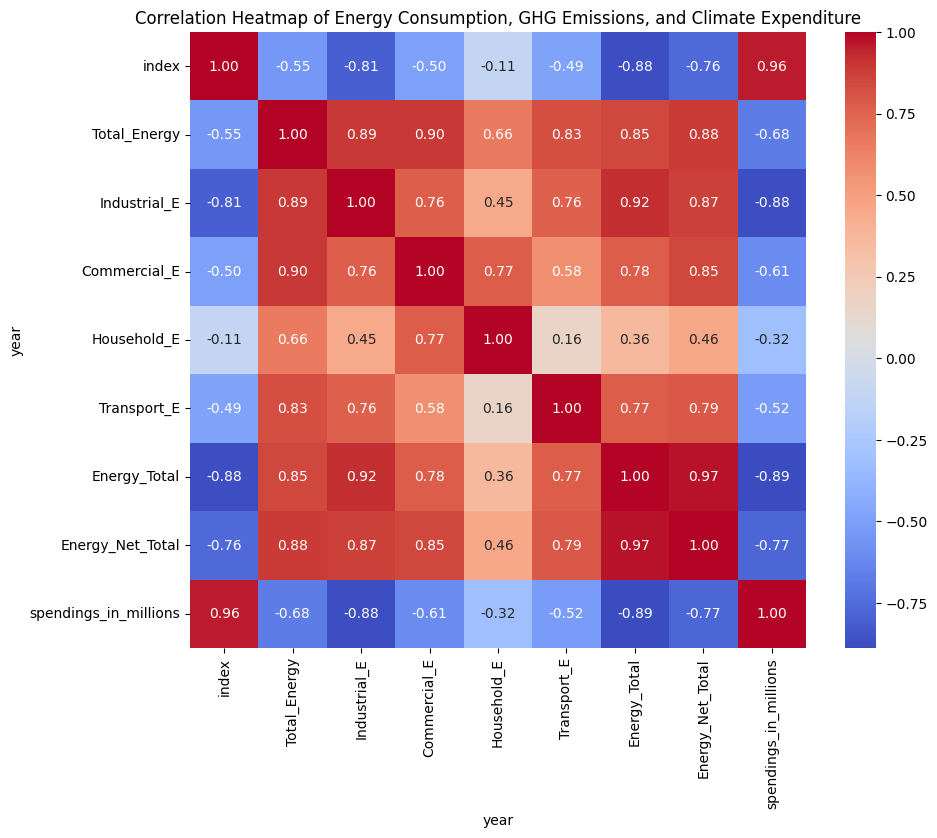

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'final_df' is your dataframe
plt.figure(figsize=(10, 8))
correlation_matrix = final_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Heatmap of Energy Consumption, GHG Emissions, and Climate Expenditure')

plt.show()

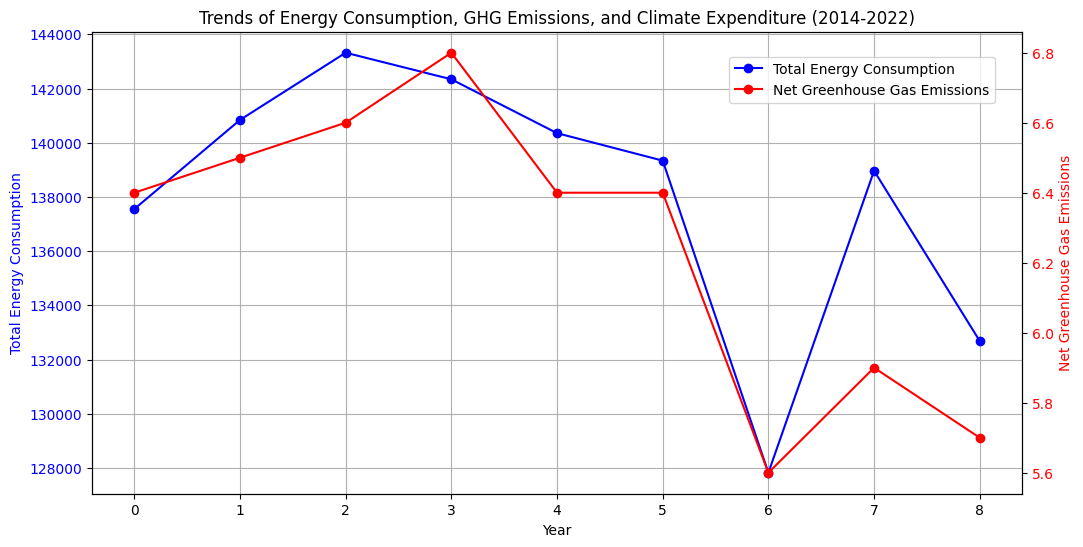

In [40]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Total_Energy and spendings_in_millions on the primary y-axis
ax1.plot(final_df.index, final_df['Total_Energy'], label='Total Energy Consumption', marker='o', color='b')
#ax1.plot(final_df.index, final_df['spendings_in_millions'], label='Climate-related Expenditure', marker='o', color='g')
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Energy Consumption', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Add data point labels for Total_Energy
#for i, txt in enumerate(final_df['Total_Energy']):
    #ax1.text(final_df.index[i], final_df['Total_Energy'][i], f'{txt:.0f}', color='black', fontsize=8, fontweight='bold', ha='right')

# Add data point labels for spendings_in_millions
#for i, txt in enumerate(final_df['spendings_in_millions']):
    #ax1.text(final_df.index[i], final_df['spendings_in_millions'][i], f'{txt:.2f}', color='black', fontsize=8, fontweight='bold', ha='right')

# Create a secondary y-axis to plot Energy_Net_Total
ax2 = ax1.twinx()
ax2.plot(final_df.index, final_df['Energy_Net_Total'], label='Net Greenhouse Gas Emissions', marker='o', color='r')
ax2.set_ylabel('Net Greenhouse Gas Emissions', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add data point labels for Energy_Net_Total
#for i, txt in enumerate(final_df['Energy_Net_Total']):
    #ax2.text(final_df.index[i], final_df['Energy_Net_Total'][i], f'{txt:.1f}', color='black', fontsize=10, fontweight='bold', ha='left')

# Add legends
fig.legend(loc='upper left', bbox_to_anchor=(0.65, 0.85))

# Title and grid
plt.title('Trends of Energy Consumption, GHG Emissions, and Climate Expenditure (2014-2022)')
ax1.grid(True)

plt.show()

In [ ]:
final_df.info()

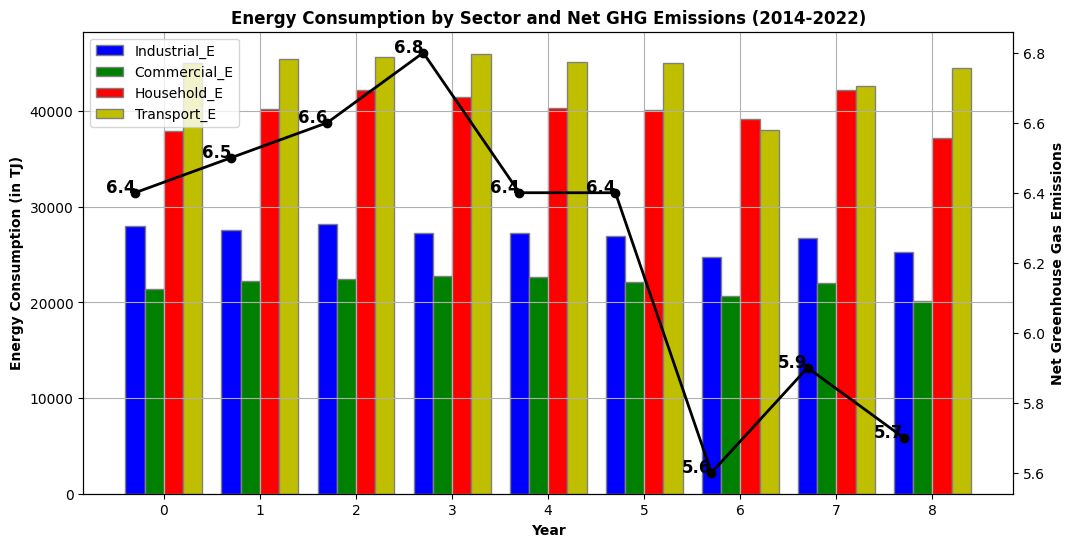

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Define the width for the bars
bar_width = 0.2

# Define the positions for the bars
r1 = np.arange(len(final_df))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Create a figure and a set of subplots with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the bar graph
ax1.bar(r1, final_df['Industrial_E'], color='b', width=bar_width, edgecolor='grey', label='Industrial_E')
ax1.bar(r2, final_df['Commercial_E'], color='g', width=bar_width, edgecolor='grey', label='Commercial_E')
ax1.bar(r3, final_df['Household_E'], color='r', width=bar_width, edgecolor='grey', label='Household_E')
ax1.bar(r4, final_df['Transport_E'], color='y', width=bar_width, edgecolor='grey', label='Transport_E')

# Add labels, title, and legend
ax1.set_xlabel('Year', fontweight='bold')
ax1.set_ylabel('Energy Consumption (in TJ)', fontweight='bold')
ax1.set_title('Energy Consumption by Sector and Net GHG Emissions (2014-2022)', fontweight='bold')
ax1.set_xticks([r + bar_width*1.5 for r in range(len(final_df))])
ax1.set_xticklabels(final_df.index)
ax1.legend(loc='upper left')

# Create a secondary y-axis to plot Energy_Net_Total
ax2 = ax1.twinx()
ax2.plot(final_df.index, final_df['Energy_Net_Total'], label='Net Greenhouse Gas Emissions', marker='o', color='black', linewidth=2)
ax2.set_ylabel('Net Greenhouse Gas Emissions', fontweight='bold')
ax2.tick_params(axis='y')

# Add data point labels for Energy_Net_Total
for i, txt in enumerate(final_df['Energy_Net_Total']):
    ax2.text(final_df.index[i], final_df['Energy_Net_Total'][i], f'{txt:.1f}', color='black', fontsize=12, fontweight='bold', ha='right')

# Add grid
ax1.grid(True)

plt.show()

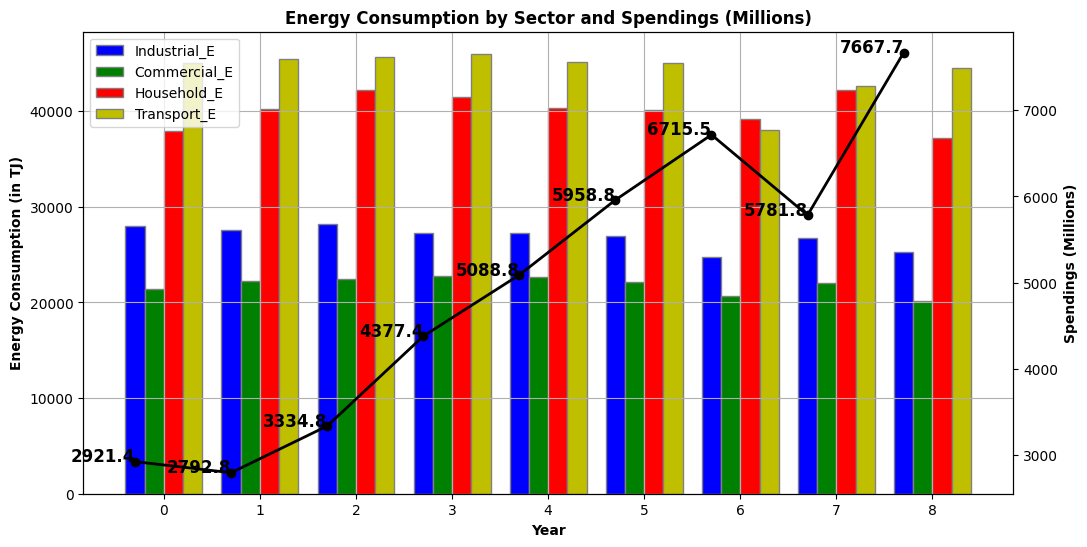

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Define the width for the bars
bar_width = 0.2

# Define the positions for the bars
r1 = np.arange(len(final_df))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Create a figure and a set of subplots with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the bar graph
ax1.bar(r1, final_df['Industrial_E'], color='b', width=bar_width, edgecolor='grey', label='Industrial_E')
ax1.bar(r2, final_df['Commercial_E'], color='g', width=bar_width, edgecolor='grey', label='Commercial_E')
ax1.bar(r3, final_df['Household_E'], color='r', width=bar_width, edgecolor='grey', label='Household_E')
ax1.bar(r4, final_df['Transport_E'], color='y', width=bar_width, edgecolor='grey', label='Transport_E')

# Add labels, title, and legend
ax1.set_xlabel('Year', fontweight='bold')
ax1.set_ylabel('Energy Consumption (in TJ)', fontweight='bold')
ax1.set_title('Energy Consumption by Sector and Spendings (Millions)', fontweight='bold')
ax1.set_xticks([r + bar_width*1.5 for r in range(len(final_df))])
ax1.set_xticklabels(final_df.index)
ax1.legend(loc='upper left')

# Create a secondary y-axis to plot Energy_Net_Total
ax2 = ax1.twinx()
ax2.plot(final_df.index, final_df['spendings_in_millions'], label='Spendings (Millions)', marker='o', color='black', linewidth=2)
ax2.set_ylabel('Spendings (Millions)', fontweight='bold')
ax2.tick_params(axis='y')

# Add data point labels for Energy_Net_Total
for i, txt in enumerate(final_df['spendings_in_millions']):
    ax2.text(final_df.index[i], final_df['spendings_in_millions'][i], f'{txt:.1f}', color='black', fontsize=12, fontweight='bold', ha='right')

# Add grid
ax1.grid(True)

plt.show()